In [53]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [55]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [56]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [57]:
tf.keras.backend.clear_session()

In [58]:
subject = 'Santa Catarina - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [59]:
data = pd.read_csv('2003_mo_model_input_SC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - Consumo de Cimento (t),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.797768,0.311113,0.807065,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,0.852921,0.752747,142.456,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,11270.272400,8.001967e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.797853,0.312787,0.806745,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,0.853282,0.752954,135.829,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,11377.902015,8.038182e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.797939,0.314207,0.806425,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,0.853644,0.753161,133.135,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,11480.211275,8.074397e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.798024,0.315571,0.806105,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,0.854005,0.753368,144.723,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,11578.298418,8.110613e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.798110,0.316880,0.805786,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,0.854366,0.753575,150.523,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,11673.320486,8.146828e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42497.575231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42463.822266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42375.031726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42265.885860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


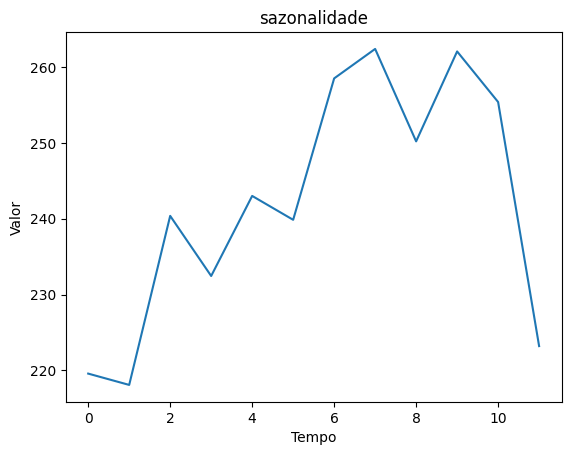

,sazonalidade
sazonalidade,
0,219.591071
1,218.098705
2,240.383349
3,232.458494
4,243.012756
5,239.863999
6,258.505989
7,262.392004
8,250.204324


In [60]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [61]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Santa Catarina - Consumo de Cimento (t)
0,2003-1,0.797768,0.311113,0.807065,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,0.852921,0.752747,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,11270.272400,8.001967e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,219.591071,142.456
1,2003-2,0.797853,0.312787,0.806745,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,0.853282,0.752954,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,11377.902015,8.038182e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,218.098705,135.829
2,2003-3,0.797939,0.314207,0.806425,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,0.853644,0.753161,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,11480.211275,8.074397e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,240.383349,133.135
3,2003-4,0.798024,0.315571,0.806105,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,0.854005,0.753368,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,11578.298418,8.110613e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,232.458494,144.723
4,2003-5,0.798110,0.316880,0.805786,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,0.854366,0.753575,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,11673.320486,8.146828e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,243.012756,150.523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42497.575231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.012756,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42463.822266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.863999,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42375.031726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.505989,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42265.885860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.392004,NaN


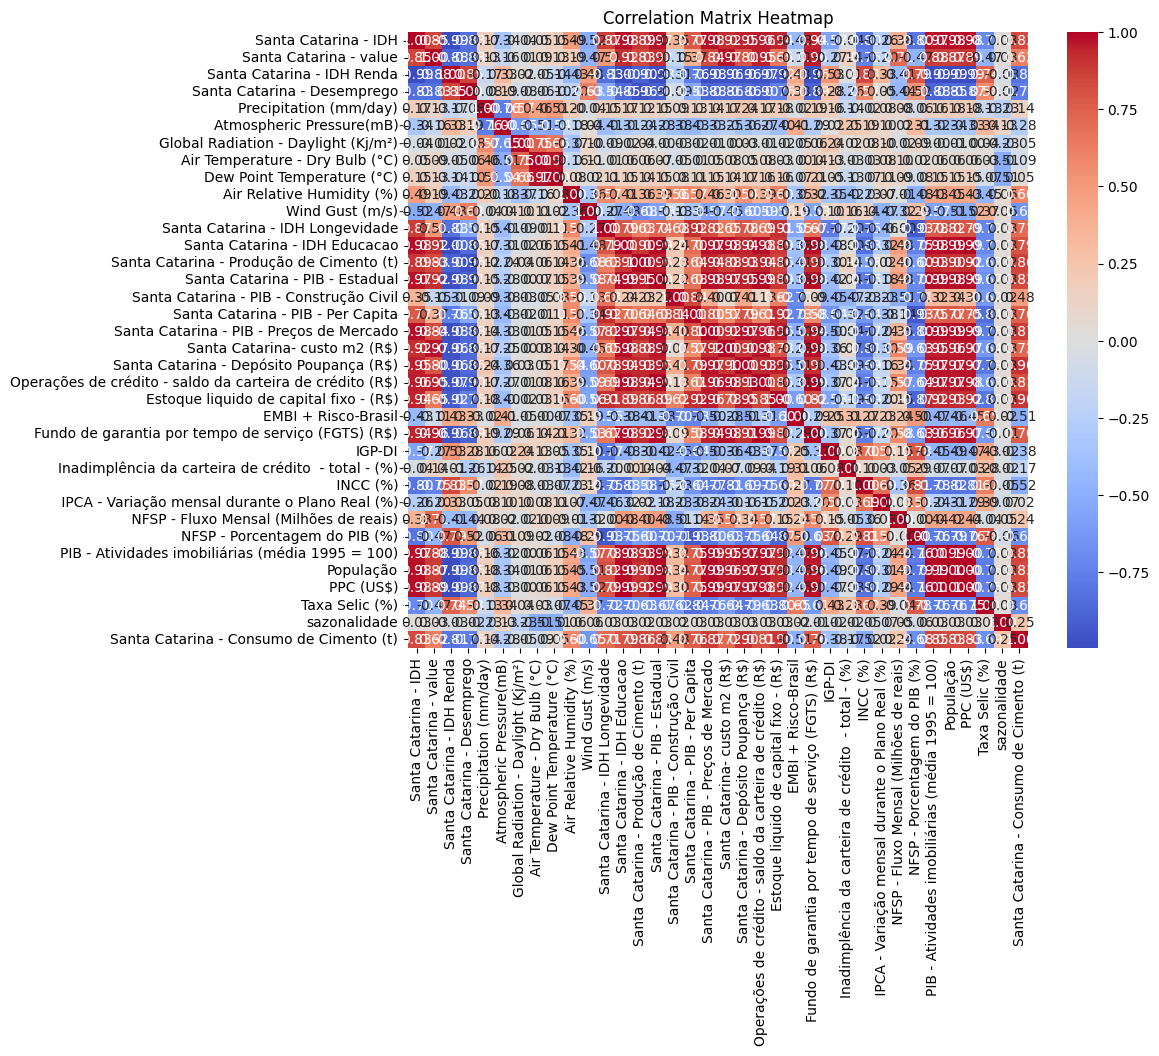

In [62]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [63]:
data = data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' IPCA - Variação mensal durante o Plano Real (%)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Temperature - Dry Bulb (°C)',
                 'Dew Point Temperature (°C)',
                 'Santa Catarina - Produção de Cimento (t)',
                 'Santa Catarina- custo m2 (R$)'], axis=1)
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Santa Catarina - Consumo de Cimento (t)
0,2003-1,0.797768,0.311113,0.807065,8.256606,1.631497,1018.765911,75.767229,2.323261,0.852921,0.752747,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,8.001967e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,219.591071,142.456
1,2003-2,0.797853,0.312787,0.806745,8.250731,1.632074,1018.754803,75.775096,2.323261,0.853282,0.752954,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,8.038182e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,218.098705,135.829
2,2003-3,0.797939,0.314207,0.806425,8.244856,1.632410,1018.748324,75.779686,2.323261,0.853644,0.753161,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,8.074397e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,240.383349,133.135
3,2003-4,0.798024,0.315571,0.806105,8.238982,1.632446,1018.747630,75.780177,2.323261,0.854005,0.753368,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,8.110613e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,232.458494,144.723
4,2003-5,0.798110,0.316880,0.805786,8.233107,1.808330,1017.949265,75.676757,2.319445,0.854366,0.753575,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,8.146828e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,243.012756,150.523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.012756,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.863999,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.505989,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.392004,NaN


In [64]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.119998,-1.030889,2.024295,1.085359,-0.310226,0.765934,-0.727872,0.818687,-2.983454,-1.858985,-1.682734,-2.417084,-3.022828,-2.152611,-1.649126,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.457186
1,-2.088248,-1.010380,1.996011,1.080851,-0.308893,0.762217,-0.724174,0.818687,-2.910442,-1.836397,-1.664640,-2.359361,-2.949421,-2.116149,-1.640320,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.553806
2,-2.056499,-0.992988,1.967728,1.076343,-0.308115,0.760048,-0.722017,0.818687,-2.837429,-1.813808,-1.646546,-2.301638,-2.876014,-2.079688,-1.631515,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.111024
3,-2.024750,-0.976287,1.939445,1.071835,-0.308031,0.759816,-0.721786,0.818687,-2.764417,-1.791219,-1.628452,-2.243915,-2.802607,-2.043226,-1.622709,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.624105
4,-1.993000,-0.960251,1.911161,1.067328,0.098681,0.492613,-0.770393,0.811417,-2.691405,-1.768630,-1.610358,-2.186191,-2.729200,-2.006765,-1.613903,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.059213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.726097,1.713104,-1.260987,-1.126590,-0.849403,0.230365,-0.011681,0.127747,-0.079851,1.393306,1.196588,-0.578473,0.290543,1.029069,1.102089,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.313890
188,0.689854,1.722266,-1.262307,-1.131368,-0.450669,-0.157519,-0.327568,0.257589,-0.144845,1.395307,1.189460,-0.568205,0.281308,1.023160,1.105854,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.524819
189,0.653611,1.738852,-1.263627,-1.136147,0.259583,-0.395131,-0.886130,0.410228,-0.209838,1.397309,1.182332,-0.557938,0.272072,1.017252,1.109618,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.292432
190,0.617368,1.755526,-1.264948,-1.140925,0.958241,-0.639022,-1.186030,0.395488,-0.274831,1.399311,1.175204,-0.547670,0.262837,1.011344,1.113382,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.860681


In [65]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      135.344
1      127.693
2      151.570
3      137.044
4      134.493
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Santa Catarina - Consumo de Cimento (t), Length: 249, dtype: float64

In [66]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.119998,-1.030889,2.024295,1.085359,-0.310226,0.765934,-0.727872,0.818687,-2.983454,-1.858985,-1.682734,-2.417084,-3.022828,-2.152611,-1.649126,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.457186
1,-2.088248,-1.010380,1.996011,1.080851,-0.308893,0.762217,-0.724174,0.818687,-2.910442,-1.836397,-1.664640,-2.359361,-2.949421,-2.116149,-1.640320,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.553806
2,-2.056499,-0.992988,1.967728,1.076343,-0.308115,0.760048,-0.722017,0.818687,-2.837429,-1.813808,-1.646546,-2.301638,-2.876014,-2.079688,-1.631515,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.111024
3,-2.024750,-0.976287,1.939445,1.071835,-0.308031,0.759816,-0.721786,0.818687,-2.764417,-1.791219,-1.628452,-2.243915,-2.802607,-2.043226,-1.622709,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.624105
4,-1.993000,-0.960251,1.911161,1.067328,0.098681,0.492613,-0.770393,0.811417,-2.691405,-1.768630,-1.610358,-2.186191,-2.729200,-2.006765,-1.613903,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.059213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.514485,1.376970,-1.306569,-0.817925,0.785994,-0.635753,0.390294,-0.252896,1.458650,1.363659,1.181211,-0.551568,0.108581,0.958937,0.672934,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.553806
158,1.496494,1.401965,-1.306296,-0.835333,0.395537,-0.146787,0.440828,-0.428457,1.417485,1.361426,1.187451,-0.577579,0.126542,0.968867,0.690901,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,-0.111024
159,1.478503,1.424150,-1.306023,-0.852741,0.143810,0.176295,0.584898,-0.456632,1.376320,1.359192,1.193692,-0.603589,0.144504,0.978796,0.708869,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-0.624105
160,1.460512,1.443460,-1.305750,-0.870149,-0.232062,0.516408,0.596740,-0.411266,1.335155,1.356958,1.199932,-0.629600,0.162465,0.988726,0.726837,1.306664,0.785801,1.017171,1.240363,-1.068274,1.048868,-1.103668,1.147619,-0.640320,0.956331,1.065381,1.083626,0.392942,0.059213


In [67]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      135.344
1      127.693
2      151.570
3      137.044
4      134.493
        ...   
157    211.861
158    258.760
159    211.393
160    249.531
161    231.359
Name: Santa Catarina - Consumo de Cimento (t), Length: 162, dtype: float64

In [68]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [69]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 29)

In [70]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.730991,0.354460,-0.687095,-1.145081,-0.403521,0.493524,0.776978,-2.173146,0.384026,0.576908,0.800980,0.503024,0.784774,0.894737,1.094407,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,1.062297
127,0.741997,0.396550,-0.679774,-1.124363,-0.586085,0.276193,0.619921,-2.118864,0.363263,0.590053,0.819811,0.473034,0.769927,0.903886,1.101788,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,1.313890
128,0.753002,0.439226,-0.672454,-1.103645,-0.548495,-0.119712,0.403538,-2.119392,0.342499,0.603198,0.838643,0.443045,0.755079,0.913035,1.109168,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.524819
129,0.764008,0.479949,-0.665134,-1.082927,-0.504857,-0.433474,0.239724,-2.050383,0.321736,0.616343,0.857474,0.413055,0.740232,0.922184,1.116549,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.292432
130,0.775014,0.523578,-0.657813,-1.062209,-0.104198,-0.737566,0.122344,-1.946826,0.300973,0.629488,0.876306,0.383065,0.725384,0.931332,1.123929,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.860681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.726097,1.713104,-1.260987,-1.126590,-0.849403,0.230365,-0.011681,0.127747,-0.079851,1.393306,1.196588,-0.578473,0.290543,1.029069,1.102089,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.313890
188,0.689854,1.722266,-1.262307,-1.131368,-0.450669,-0.157519,-0.327568,0.257589,-0.144845,1.395307,1.189460,-0.568205,0.281308,1.023160,1.105854,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.524819
189,0.653611,1.738852,-1.263627,-1.136147,0.259583,-0.395131,-0.886130,0.410228,-0.209838,1.397309,1.182332,-0.557938,0.272072,1.017252,1.109618,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.292432
190,0.617368,1.755526,-1.264948,-1.140925,0.958241,-0.639022,-1.186030,0.395488,-0.274831,1.399311,1.175204,-0.547670,0.262837,1.011344,1.113382,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.860681


In [71]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 29)

In [72]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [73]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [74]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [75]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3825343452, 1339709032, 1572031022, 2819828343, 647582252, 2618974828, 591988342, 3063571061, 333651743, 1603629973, 1666236195, 3563057827, 4107569041, 295717291, 2368056758, 2551830781, 184287058, 1777660988, 3930450925, 1417743840, 1203299566, 1251601840, 3019717551, 3682071703, 2451358277, 3054870742, 3233082633, 1802740181, 829310807, 721423124, 1432272762, 439716137, 2546717526, 1148893027, 754387072, 887858932, 3971219225, 3491726974, 2385104824, 3998688634, 2464942896, 3811111085, 3810643808, 1289046496, 1165927077, 1597517874, 4247873784, 1234329039, 654145109, 1653244395]


Step: 0 ___________________________________________
val_loss: 346.68194580078125
winner_seed: 3825343452


Step: 1 ___________________________________________
val_loss: 785.010009765625


Step: 2 ___________________________________________
val_loss: 215.59991455078125
winner_seed: 1572031022


Step: 3 ___________________________________________
val_loss: 340.7292175292969


Step: 4 _______________________

In [76]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 116ms/step - loss: 42828.4766 - val_loss: 2166.3091
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 2265.0833 - val_loss: 1759.2952
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 2004.5437 - val_loss: 1848.7548
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 1999.0604 - val_loss: 1573.0028
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 1878.7897 - val_loss: 1498.8467
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 1807.9307 - val_loss: 1952.2522
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 2146.9331 - val_loss: 1545.1163
Epoch 8/10000
4/4 [==============================] - 0s 8ms/step - loss: 1981.1218 - val_loss: 1625.3542
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 1900.4249 - val_loss: 3591.1519
Epoch 10/10000
4/4 [==============================

Epoch 79/10000
4/4 [==============================] - 0s 9ms/step - loss: 882.2184 - val_loss: 879.8320
Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 824.5851 - val_loss: 752.7181
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 967.0300 - val_loss: 1005.4392
Epoch 82/10000
4/4 [==============================] - 0s 8ms/step - loss: 969.5214 - val_loss: 807.1550
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 755.4092 - val_loss: 972.4986
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 799.7435 - val_loss: 733.9733
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 631.5871 - val_loss: 654.4524
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 676.7762 - val_loss: 732.3996
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 660.1397 - val_loss: 714.6208
Epoch 88/10000
4/4 [==============================] - 0s 9ms

Epoch 157/10000
4/4 [==============================] - 0s 12ms/step - loss: 340.5605 - val_loss: 550.5300
Epoch 158/10000
4/4 [==============================] - 0s 10ms/step - loss: 304.9397 - val_loss: 478.2198
Epoch 159/10000
4/4 [==============================] - 0s 10ms/step - loss: 247.8294 - val_loss: 474.8522
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 296.6705 - val_loss: 450.5311
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 267.6104 - val_loss: 500.3740
Epoch 162/10000
4/4 [==============================] - 0s 11ms/step - loss: 276.7320 - val_loss: 468.0610
Epoch 163/10000
4/4 [==============================] - 0s 10ms/step - loss: 331.3420 - val_loss: 545.6335
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 279.7391 - val_loss: 489.8677
Epoch 165/10000
4/4 [==============================] - 0s 12ms/step - loss: 313.9888 - val_loss: 709.5032
Epoch 166/10000
4/4 [==========================

4/4 [==============================] - 0s 8ms/step - loss: 247.7093 - val_loss: 416.2223
Epoch 235/10000
4/4 [==============================] - 0s 8ms/step - loss: 201.6943 - val_loss: 365.0883
Epoch 236/10000
4/4 [==============================] - 0s 7ms/step - loss: 270.1604 - val_loss: 359.5191
Epoch 237/10000
4/4 [==============================] - 0s 7ms/step - loss: 238.1781 - val_loss: 456.2773
Epoch 238/10000
4/4 [==============================] - 0s 7ms/step - loss: 263.6292 - val_loss: 360.7862
Epoch 239/10000
4/4 [==============================] - 0s 7ms/step - loss: 191.8913 - val_loss: 393.1735
Epoch 240/10000
4/4 [==============================] - 0s 7ms/step - loss: 226.0093 - val_loss: 407.6345
Epoch 241/10000
4/4 [==============================] - 0s 7ms/step - loss: 228.0626 - val_loss: 385.9207
Epoch 242/10000
4/4 [==============================] - 0s 7ms/step - loss: 237.5235 - val_loss: 414.0403
Epoch 243/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 190.2249 - val_loss: 493.6401
Epoch 313/10000
4/4 [==============================] - 0s 10ms/step - loss: 214.0113 - val_loss: 457.6772
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 142.8256 - val_loss: 407.5278
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 200.3848 - val_loss: 499.2861
Epoch 316/10000
4/4 [==============================] - 0s 9ms/step - loss: 193.7577 - val_loss: 472.9424
Epoch 317/10000
4/4 [==============================] - 0s 8ms/step - loss: 220.9823 - val_loss: 560.5187
Epoch 318/10000
4/4 [==============================] - 0s 8ms/step - loss: 199.4124 - val_loss: 386.8611
Epoch 319/10000
4/4 [==============================] - 0s 8ms/step - loss: 186.9027 - val_loss: 403.7882
Epoch 320/10000
4/4 [==============================] - 0s 9ms/step - loss: 195.6039 - val_loss: 375.0897
Epoch 321/10000
4/4 [==============================] - 0s 9ms/step 

Epoch 390/10000
4/4 [==============================] - 0s 10ms/step - loss: 198.8378 - val_loss: 423.0210
Epoch 391/10000
4/4 [==============================] - 0s 9ms/step - loss: 177.6738 - val_loss: 384.0897
Epoch 392/10000
4/4 [==============================] - 0s 10ms/step - loss: 177.9692 - val_loss: 375.6886
Epoch 393/10000
4/4 [==============================] - 0s 10ms/step - loss: 152.8365 - val_loss: 361.2699
Epoch 394/10000
4/4 [==============================] - 0s 9ms/step - loss: 155.0328 - val_loss: 338.4313
Epoch 395/10000
4/4 [==============================] - 0s 9ms/step - loss: 175.6709 - val_loss: 375.9781
Epoch 396/10000
4/4 [==============================] - 0s 9ms/step - loss: 199.9454 - val_loss: 417.2381
Epoch 397/10000
4/4 [==============================] - 0s 8ms/step - loss: 222.6294 - val_loss: 420.5370
Epoch 398/10000
4/4 [==============================] - 0s 9ms/step - loss: 222.7256 - val_loss: 365.7550
Epoch 399/10000
4/4 [==============================]

Epoch 468/10000
4/4 [==============================] - 0s 9ms/step - loss: 164.9307 - val_loss: 496.8275
Epoch 469/10000
4/4 [==============================] - 0s 9ms/step - loss: 153.8699 - val_loss: 462.7999
Epoch 470/10000
4/4 [==============================] - 0s 10ms/step - loss: 207.4324 - val_loss: 534.1216
Epoch 471/10000
4/4 [==============================] - 0s 10ms/step - loss: 235.5072 - val_loss: 482.4184
Epoch 472/10000
4/4 [==============================] - 0s 9ms/step - loss: 246.7133 - val_loss: 456.1455
Epoch 473/10000
4/4 [==============================] - 0s 8ms/step - loss: 203.0278 - val_loss: 456.8795
Epoch 474/10000
4/4 [==============================] - 0s 8ms/step - loss: 147.0407 - val_loss: 458.2621
Epoch 475/10000
4/4 [==============================] - 0s 8ms/step - loss: 182.7538 - val_loss: 360.2869
Epoch 476/10000
4/4 [==============================] - 0s 9ms/step - loss: 194.0415 - val_loss: 360.3931
Epoch 477/10000
4/4 [==============================] 

4/4 [==============================] - 0s 9ms/step - loss: 133.8575 - val_loss: 392.6705
Epoch 546/10000
4/4 [==============================] - 0s 10ms/step - loss: 149.1044 - val_loss: 451.3701
Epoch 547/10000
4/4 [==============================] - 0s 9ms/step - loss: 163.7027 - val_loss: 380.6675
Epoch 548/10000
4/4 [==============================] - 0s 9ms/step - loss: 160.4176 - val_loss: 409.7823
Epoch 549/10000
4/4 [==============================] - 0s 9ms/step - loss: 182.8474 - val_loss: 378.5685
Epoch 550/10000
4/4 [==============================] - 0s 8ms/step - loss: 117.7028 - val_loss: 493.6893
Epoch 551/10000
4/4 [==============================] - 0s 9ms/step - loss: 150.6653 - val_loss: 435.4949
Epoch 552/10000
4/4 [==============================] - 0s 11ms/step - loss: 183.8259 - val_loss: 432.4880
Epoch 553/10000
4/4 [==============================] - 0s 10ms/step - loss: 152.0271 - val_loss: 428.2352
Epoch 554/10000
4/4 [==============================] - 0s 9ms/step -

4/4 [==============================] - 0s 11ms/step - loss: 119.0102 - val_loss: 405.6472
Epoch 623/10000
4/4 [==============================] - 0s 10ms/step - loss: 165.7829 - val_loss: 502.4015
Epoch 624/10000
4/4 [==============================] - 0s 10ms/step - loss: 207.9562 - val_loss: 418.5519
Epoch 625/10000
4/4 [==============================] - 0s 10ms/step - loss: 127.2690 - val_loss: 462.0945
Epoch 626/10000
4/4 [==============================] - 0s 10ms/step - loss: 137.5109 - val_loss: 444.5432
Epoch 627/10000
4/4 [==============================] - 0s 11ms/step - loss: 135.4129 - val_loss: 466.4532
Epoch 628/10000
4/4 [==============================] - 0s 11ms/step - loss: 118.3557 - val_loss: 480.6728
Epoch 629/10000
4/4 [==============================] - 0s 11ms/step - loss: 120.8224 - val_loss: 472.0946
Epoch 630/10000
4/4 [==============================] - 0s 11ms/step - loss: 166.5428 - val_loss: 472.9196
Epoch 631/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 13ms/step - loss: 127.7411 - val_loss: 426.5101
Epoch 700/10000
4/4 [==============================] - 0s 12ms/step - loss: 137.1678 - val_loss: 358.9039
Epoch 701/10000
4/4 [==============================] - 0s 11ms/step - loss: 113.9872 - val_loss: 341.1966
Epoch 702/10000
4/4 [==============================] - 0s 11ms/step - loss: 121.7343 - val_loss: 358.3482
Epoch 703/10000
4/4 [==============================] - 0s 12ms/step - loss: 133.0577 - val_loss: 468.8259
Epoch 704/10000
4/4 [==============================] - 0s 12ms/step - loss: 127.8431 - val_loss: 448.1169
Epoch 705/10000
4/4 [==============================] - 0s 11ms/step - loss: 127.5271 - val_loss: 485.6508
Epoch 706/10000
4/4 [==============================] - 0s 12ms/step - loss: 126.6625 - val_loss: 473.4748
Epoch 707/10000
4/4 [==============================] - 0s 11ms/step - loss: 165.9278 - val_loss: 444.3086
Epoch 708/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 112.6069 - val_loss: 378.3401
Epoch 777/10000
4/4 [==============================] - 0s 11ms/step - loss: 163.6276 - val_loss: 344.4998
Epoch 778/10000
4/4 [==============================] - 0s 11ms/step - loss: 137.6137 - val_loss: 330.7327
Epoch 779/10000
4/4 [==============================] - 0s 12ms/step - loss: 103.1568 - val_loss: 404.1560
Epoch 780/10000
4/4 [==============================] - 0s 12ms/step - loss: 127.0818 - val_loss: 361.1911
Epoch 781/10000
4/4 [==============================] - 0s 12ms/step - loss: 152.7377 - val_loss: 344.5155
Epoch 782/10000
4/4 [==============================] - 0s 11ms/step - loss: 173.1236 - val_loss: 291.6778
Epoch 783/10000
4/4 [==============================] - 0s 12ms/step - loss: 119.5525 - val_loss: 237.7803
Epoch 784/10000
4/4 [==============================] - 0s 12ms/step - loss: 141.8159 - val_loss: 303.0423
Epoch 785/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 139.2184 - val_loss: 340.2790
Epoch 854/10000
4/4 [==============================] - 0s 12ms/step - loss: 135.1355 - val_loss: 262.9165
Epoch 855/10000
4/4 [==============================] - 0s 11ms/step - loss: 110.2633 - val_loss: 260.8690
Epoch 856/10000
4/4 [==============================] - 0s 11ms/step - loss: 127.7245 - val_loss: 282.7483
Epoch 857/10000
4/4 [==============================] - 0s 11ms/step - loss: 151.9382 - val_loss: 283.0443
Epoch 858/10000
4/4 [==============================] - 0s 11ms/step - loss: 139.8569 - val_loss: 263.0467
Epoch 859/10000
4/4 [==============================] - 0s 11ms/step - loss: 111.7449 - val_loss: 297.1812
Epoch 860/10000
4/4 [==============================] - 0s 12ms/step - loss: 154.0641 - val_loss: 359.2389
Epoch 861/10000
4/4 [==============================] - 0s 14ms/step - loss: 140.7040 - val_loss: 325.6463
Epoch 862/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 107.6571 - val_loss: 360.7795
Epoch 931/10000
4/4 [==============================] - 0s 11ms/step - loss: 110.0182 - val_loss: 316.4690
Epoch 932/10000
4/4 [==============================] - 0s 11ms/step - loss: 107.8341 - val_loss: 283.5867
Epoch 933/10000
4/4 [==============================] - 0s 11ms/step - loss: 116.8812 - val_loss: 274.6490
Epoch 934/10000
4/4 [==============================] - 0s 12ms/step - loss: 106.8712 - val_loss: 265.2668
Epoch 935/10000
4/4 [==============================] - 0s 11ms/step - loss: 126.6626 - val_loss: 308.7236
Epoch 936/10000
4/4 [==============================] - 0s 11ms/step - loss: 118.8425 - val_loss: 354.2872
Epoch 937/10000
4/4 [==============================] - 0s 11ms/step - loss: 148.5880 - val_loss: 296.6630
Epoch 938/10000
4/4 [==============================] - 0s 12ms/step - loss: 118.2700 - val_loss: 265.3642
Epoch 939/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 12ms/step - loss: 87.5689 - val_loss: 300.6900
Epoch 1008/10000
4/4 [==============================] - 0s 12ms/step - loss: 119.8421 - val_loss: 270.4049
Epoch 1009/10000
4/4 [==============================] - 0s 11ms/step - loss: 100.2900 - val_loss: 277.6189
Epoch 1010/10000
4/4 [==============================] - 0s 12ms/step - loss: 101.0780 - val_loss: 290.7746
Epoch 1011/10000
4/4 [==============================] - 0s 11ms/step - loss: 97.2583 - val_loss: 281.4359
Epoch 1012/10000
4/4 [==============================] - 0s 12ms/step - loss: 108.9814 - val_loss: 290.8072
Epoch 1013/10000
4/4 [==============================] - 0s 11ms/step - loss: 98.3903 - val_loss: 300.1521
Epoch 1014/10000
4/4 [==============================] - 0s 10ms/step - loss: 87.0483 - val_loss: 336.9253
Epoch 1015/10000
4/4 [==============================] - 0s 11ms/step - loss: 101.1544 - val_loss: 304.9117
Epoch 1016/10000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 11ms/step - loss: 107.1920 - val_loss: 294.0480
Epoch 1085/10000
4/4 [==============================] - 0s 10ms/step - loss: 104.1794 - val_loss: 337.8031
Epoch 1086/10000
4/4 [==============================] - 0s 11ms/step - loss: 126.0623 - val_loss: 337.8067
Epoch 1087/10000
4/4 [==============================] - 0s 11ms/step - loss: 110.6453 - val_loss: 313.4189
Epoch 1088/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.0390 - val_loss: 313.4077
Epoch 1089/10000
4/4 [==============================] - 0s 12ms/step - loss: 107.9292 - val_loss: 354.1948
Epoch 1090/10000
4/4 [==============================] - 0s 11ms/step - loss: 105.1958 - val_loss: 314.9475
Epoch 1091/10000
4/4 [==============================] - 0s 12ms/step - loss: 93.9520 - val_loss: 313.1180
Epoch 1092/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.8488 - val_loss: 314.9510
Epoch 1093/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 12ms/step - loss: 82.4223 - val_loss: 285.2996
Epoch 1162/10000
4/4 [==============================] - 0s 12ms/step - loss: 104.8035 - val_loss: 256.9018
Epoch 1163/10000
4/4 [==============================] - 0s 11ms/step - loss: 69.0482 - val_loss: 258.5956
Epoch 1164/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.9345 - val_loss: 250.1117
Epoch 1165/10000
4/4 [==============================] - 0s 11ms/step - loss: 76.9066 - val_loss: 248.4488
Epoch 1166/10000
4/4 [==============================] - 0s 12ms/step - loss: 84.8120 - val_loss: 227.2585
Epoch 1167/10000
4/4 [==============================] - 0s 12ms/step - loss: 59.8871 - val_loss: 239.9392
Epoch 1168/10000
4/4 [==============================] - 0s 12ms/step - loss: 90.6630 - val_loss: 240.8783
Epoch 1169/10000
4/4 [==============================] - 0s 14ms/step - loss: 114.8948 - val_loss: 236.8074
Epoch 1170/10000
4/4 [==============================] - 0s 12

4/4 [==============================] - 0s 10ms/step - loss: 91.2852 - val_loss: 380.8885
Epoch 1239/10000
4/4 [==============================] - 0s 10ms/step - loss: 91.2656 - val_loss: 362.2281
Epoch 1240/10000
4/4 [==============================] - 0s 11ms/step - loss: 83.4587 - val_loss: 352.9275
Epoch 1241/10000
4/4 [==============================] - 0s 12ms/step - loss: 101.0335 - val_loss: 359.9283
Epoch 1242/10000
4/4 [==============================] - 0s 11ms/step - loss: 107.8071 - val_loss: 357.5417
Epoch 1243/10000
4/4 [==============================] - 0s 12ms/step - loss: 66.6936 - val_loss: 349.3550
Epoch 1244/10000
4/4 [==============================] - 0s 11ms/step - loss: 101.8908 - val_loss: 376.3986
Epoch 1245/10000
4/4 [==============================] - 0s 11ms/step - loss: 102.0477 - val_loss: 356.9248
Epoch 1246/10000
4/4 [==============================] - 0s 10ms/step - loss: 76.3265 - val_loss: 344.4011
Epoch 1247/10000
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 11ms/step - loss: 107.9462 - val_loss: 221.7153
Epoch 1316/10000
4/4 [==============================] - 0s 13ms/step - loss: 100.7063 - val_loss: 222.1987
Epoch 1317/10000
4/4 [==============================] - 0s 11ms/step - loss: 72.0181 - val_loss: 222.3272
Epoch 1318/10000
4/4 [==============================] - 0s 11ms/step - loss: 90.1392 - val_loss: 258.5987
Epoch 1319/10000
4/4 [==============================] - 0s 11ms/step - loss: 96.9788 - val_loss: 231.2186
Epoch 1320/10000
4/4 [==============================] - 0s 12ms/step - loss: 102.0557 - val_loss: 287.8204
Epoch 1321/10000
4/4 [==============================] - 0s 12ms/step - loss: 120.2444 - val_loss: 246.4258
Epoch 1322/10000
4/4 [==============================] - 0s 11ms/step - loss: 72.9789 - val_loss: 213.5356
Epoch 1323/10000
4/4 [==============================] - 0s 11ms/step - loss: 109.7301 - val_loss: 244.5084
Epoch 1324/10000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 12ms/step - loss: 120.0057 - val_loss: 231.9830
Epoch 1393/10000
4/4 [==============================] - 0s 11ms/step - loss: 90.5612 - val_loss: 254.1438
Epoch 1394/10000
4/4 [==============================] - 0s 12ms/step - loss: 74.2590 - val_loss: 256.8655
Epoch 1395/10000
4/4 [==============================] - 0s 11ms/step - loss: 84.3795 - val_loss: 239.0979
Epoch 1396/10000
4/4 [==============================] - 0s 11ms/step - loss: 84.4050 - val_loss: 228.9259
Epoch 1397/10000
4/4 [==============================] - 0s 11ms/step - loss: 56.5180 - val_loss: 260.0980
Epoch 1398/10000
4/4 [==============================] - 0s 12ms/step - loss: 81.4445 - val_loss: 249.6930
Epoch 1399/10000
4/4 [==============================] - 0s 11ms/step - loss: 78.9704 - val_loss: 245.6590
Epoch 1400/10000
4/4 [==============================] - 0s 11ms/step - loss: 110.1690 - val_loss: 279.8082
Epoch 1401/10000
4/4 [==============================] - 0s 11

4/4 [==============================] - 0s 10ms/step - loss: 99.9673 - val_loss: 205.5174
Epoch 1470/10000
4/4 [==============================] - 0s 10ms/step - loss: 100.4593 - val_loss: 218.5034
Epoch 1471/10000
4/4 [==============================] - 0s 10ms/step - loss: 91.0537 - val_loss: 212.4798
Epoch 1472/10000
4/4 [==============================] - 0s 11ms/step - loss: 106.0326 - val_loss: 231.7643
Epoch 1473/10000
4/4 [==============================] - 0s 11ms/step - loss: 77.2748 - val_loss: 214.3387
Epoch 1474/10000
4/4 [==============================] - 0s 10ms/step - loss: 106.6447 - val_loss: 312.6933
Epoch 1475/10000
4/4 [==============================] - 0s 12ms/step - loss: 108.8173 - val_loss: 238.0248
Epoch 1476/10000
4/4 [==============================] - 0s 12ms/step - loss: 97.8458 - val_loss: 216.5651
Epoch 1477/10000
4/4 [==============================] - 0s 10ms/step - loss: 81.4773 - val_loss: 242.1906
Epoch 1478/10000
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 10ms/step - loss: 95.4477 - val_loss: 296.3608
Epoch 1547/10000
4/4 [==============================] - 0s 10ms/step - loss: 69.1120 - val_loss: 276.4140
Epoch 1548/10000
4/4 [==============================] - 0s 11ms/step - loss: 90.4620 - val_loss: 251.3797
Epoch 1549/10000
4/4 [==============================] - 0s 12ms/step - loss: 80.9824 - val_loss: 227.0873
Epoch 1550/10000
4/4 [==============================] - 0s 11ms/step - loss: 67.0039 - val_loss: 224.2115
Epoch 1551/10000
4/4 [==============================] - 0s 10ms/step - loss: 92.6386 - val_loss: 287.1611
Epoch 1552/10000
4/4 [==============================] - 0s 11ms/step - loss: 86.7628 - val_loss: 224.4228
Epoch 1553/10000
4/4 [==============================] - 0s 11ms/step - loss: 74.8308 - val_loss: 223.2219
Epoch 1554/10000
4/4 [==============================] - 0s 12ms/step - loss: 86.0303 - val_loss: 253.4016
Epoch 1555/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 9ms/step - loss: 78.4401 - val_loss: 218.4012
Epoch 1624/10000
4/4 [==============================] - 0s 10ms/step - loss: 82.5980 - val_loss: 265.7172
Epoch 1625/10000
4/4 [==============================] - 0s 10ms/step - loss: 81.9191 - val_loss: 210.0540
Epoch 1626/10000
4/4 [==============================] - 0s 10ms/step - loss: 65.1772 - val_loss: 208.2880
Epoch 1627/10000
4/4 [==============================] - 0s 10ms/step - loss: 118.9550 - val_loss: 214.6065
Epoch 1628/10000
4/4 [==============================] - 0s 10ms/step - loss: 69.1494 - val_loss: 240.3456
Epoch 1629/10000
4/4 [==============================] - 0s 11ms/step - loss: 90.2298 - val_loss: 223.0076
Epoch 1630/10000
4/4 [==============================] - 0s 11ms/step - loss: 95.8256 - val_loss: 212.5720
Epoch 1631/10000
4/4 [==============================] - 0s 9ms/step - loss: 71.0787 - val_loss: 223.9875
Epoch 1632/10000
4/4 [==============================] - 0s 9ms/s

4/4 [==============================] - 0s 10ms/step - loss: 67.4286 - val_loss: 222.5168
Epoch 1701/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.8020 - val_loss: 218.8525
Epoch 1702/10000
4/4 [==============================] - 0s 10ms/step - loss: 69.6343 - val_loss: 232.5488
Epoch 1703/10000
4/4 [==============================] - 0s 11ms/step - loss: 84.6040 - val_loss: 256.3511
Epoch 1704/10000
4/4 [==============================] - 0s 11ms/step - loss: 67.4735 - val_loss: 297.7301
Epoch 1705/10000
4/4 [==============================] - 0s 12ms/step - loss: 116.0493 - val_loss: 205.8724
Epoch 1706/10000
4/4 [==============================] - 0s 11ms/step - loss: 93.0114 - val_loss: 218.1230
Epoch 1707/10000
4/4 [==============================] - 0s 10ms/step - loss: 100.5118 - val_loss: 238.4186
Epoch 1708/10000
4/4 [==============================] - 0s 11ms/step - loss: 58.6665 - val_loss: 207.2661
Epoch 1709/10000
4/4 [==============================] - 0s 12

4/4 [==============================] - 0s 11ms/step - loss: 68.5010 - val_loss: 306.4596
Epoch 1778/10000
4/4 [==============================] - 0s 11ms/step - loss: 60.8926 - val_loss: 294.6060
Epoch 1779/10000
4/4 [==============================] - 0s 11ms/step - loss: 63.5158 - val_loss: 290.6647
Epoch 1780/10000
4/4 [==============================] - 0s 11ms/step - loss: 85.8808 - val_loss: 259.4032
Epoch 1781/10000
4/4 [==============================] - 0s 11ms/step - loss: 60.3875 - val_loss: 277.6238
Epoch 1782/10000
4/4 [==============================] - 0s 11ms/step - loss: 53.7285 - val_loss: 297.8530
Epoch 1783/10000
4/4 [==============================] - 0s 11ms/step - loss: 70.5498 - val_loss: 273.4008
Epoch 1784/10000
4/4 [==============================] - 0s 11ms/step - loss: 67.6768 - val_loss: 277.2972
Epoch 1785/10000
4/4 [==============================] - 0s 11ms/step - loss: 43.3840 - val_loss: 302.3870
Epoch 1786/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 13ms/step - loss: 53.9837 - val_loss: 215.0762
Epoch 1855/10000
4/4 [==============================] - 0s 11ms/step - loss: 75.6972 - val_loss: 227.5535
Epoch 1856/10000
4/4 [==============================] - 0s 11ms/step - loss: 71.7812 - val_loss: 239.8896
Epoch 1857/10000
4/4 [==============================] - 0s 11ms/step - loss: 41.5003 - val_loss: 234.3964
Epoch 1858/10000
4/4 [==============================] - 0s 12ms/step - loss: 56.5663 - val_loss: 244.4358
Epoch 1859/10000
4/4 [==============================] - 0s 12ms/step - loss: 48.5963 - val_loss: 232.9532
Epoch 1860/10000
4/4 [==============================] - 0s 12ms/step - loss: 64.2017 - val_loss: 243.5391
Epoch 1861/10000
4/4 [==============================] - 0s 12ms/step - loss: 80.5193 - val_loss: 222.8376
Epoch 1862/10000
4/4 [==============================] - 0s 11ms/step - loss: 55.7025 - val_loss: 233.8886
Epoch 1863/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 77.6367 - val_loss: 226.2087
Epoch 1932/10000
4/4 [==============================] - 0s 11ms/step - loss: 70.4177 - val_loss: 225.4062
Epoch 1933/10000
4/4 [==============================] - 0s 12ms/step - loss: 73.2636 - val_loss: 290.7429
Epoch 1934/10000
4/4 [==============================] - 0s 11ms/step - loss: 101.3300 - val_loss: 231.2808
Epoch 1935/10000
4/4 [==============================] - 0s 11ms/step - loss: 53.6318 - val_loss: 272.9391
Epoch 1936/10000
4/4 [==============================] - 0s 11ms/step - loss: 85.5250 - val_loss: 231.8337
Epoch 1937/10000
4/4 [==============================] - 0s 11ms/step - loss: 77.6381 - val_loss: 233.8451
Epoch 1938/10000
4/4 [==============================] - 0s 12ms/step - loss: 56.3356 - val_loss: 222.3706
Epoch 1939/10000
4/4 [==============================] - 0s 11ms/step - loss: 67.4606 - val_loss: 223.0320
Epoch 1940/10000
4/4 [==============================] - 0s 11m

4/4 [==============================] - 0s 11ms/step - loss: 91.5223 - val_loss: 292.0553
Epoch 2009/10000
4/4 [==============================] - 0s 11ms/step - loss: 55.4062 - val_loss: 261.1773
Epoch 2010/10000
4/4 [==============================] - 0s 11ms/step - loss: 61.7756 - val_loss: 266.2028
Epoch 2011/10000
4/4 [==============================] - 0s 11ms/step - loss: 58.8209 - val_loss: 272.2578
Epoch 2012/10000
4/4 [==============================] - 0s 12ms/step - loss: 65.6735 - val_loss: 240.6022
Epoch 2013/10000
4/4 [==============================] - 0s 12ms/step - loss: 61.8012 - val_loss: 229.8571
Epoch 2014/10000
4/4 [==============================] - 0s 11ms/step - loss: 62.5713 - val_loss: 292.6616
Epoch 2015/10000
4/4 [==============================] - 0s 13ms/step - loss: 115.2430 - val_loss: 271.5085
Epoch 2016/10000
4/4 [==============================] - 0s 12ms/step - loss: 86.6328 - val_loss: 239.7971
Epoch 2017/10000
4/4 [==============================] - 0s 11m

4/4 [==============================] - 0s 11ms/step - loss: 53.6320 - val_loss: 235.0594
Epoch 2086/10000
4/4 [==============================] - 0s 11ms/step - loss: 43.6144 - val_loss: 221.8924
Epoch 2087/10000
4/4 [==============================] - 0s 11ms/step - loss: 70.7274 - val_loss: 223.9398
Epoch 2088/10000
4/4 [==============================] - 0s 12ms/step - loss: 57.5748 - val_loss: 277.8164
Epoch 2089/10000
4/4 [==============================] - 0s 12ms/step - loss: 56.0592 - val_loss: 241.7532
Epoch 2090/10000
4/4 [==============================] - 0s 12ms/step - loss: 63.1497 - val_loss: 252.5580
Epoch 2091/10000
4/4 [==============================] - 0s 12ms/step - loss: 55.2566 - val_loss: 288.7466
Epoch 2092/10000
4/4 [==============================] - 0s 13ms/step - loss: 74.9743 - val_loss: 261.9348
Epoch 2093/10000
4/4 [==============================] - 0s 12ms/step - loss: 68.4974 - val_loss: 244.8621
Epoch 2094/10000
4/4 [==============================] - 0s 12ms

In [77]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [78]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,253.327835,257.043945,252.77713,257.78009,245.679337,217.258118,217.054169,216.176392,223.371338,216.183548,226.382233,224.641968,258.398041,252.333466,230.192719,255.660919,235.837799,233.763306,230.796066,222.377792,226.212479,222.385941,217.686737,218.92482,223.694427,223.766754,215.518219,224.056656,218.982056,223.294678
Target,265.999,277.169,245.824,244.227,263.751,211.136,219.002,234.275,249.92,246.326,198.778,285.97,262.597,277.811,235.885,272.671,278.592,214.658,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,12.671158,20.125061,6.953125,13.553085,18.071671,6.122116,1.94783,18.098602,26.54866,30.142456,27.604233,61.328033,4.198944,25.477539,5.692276,17.010071,42.754211,19.105301,21.903931,23.768204,29.660522,50.913071,53.231262,37.680191,79.831573,75.517242,69.031769,83.519333,62.33493,2.938324


In [79]:
display(mae)
display(mape)

31.591154

0.11663726

In [80]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [81]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[2807.6763]] - Target[2942.3769999999995]| =  Error: [[134.70068]]; MAPE:[[0.04577955]]
1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[2804.57]] - Target[3097.755]| =  Error: [[293.1848]]; MAPE:[[0.09464429]]
1/1 [==============================] - 0s 16ms/step
Ano-5: |Prediction[[1329.3127]] - Target[1702.4859999999999]| =  Error: [[373.17322]]; MAPE:[[0.21919313]]


[array([[134.70068]], dtype=float32),
 array([[293.1848]], dtype=float32),
 array([[373.17322]], dtype=float32)]

267.01956

0.119872324